In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from predict_test_data import predict_test_data

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('../data/cleaned/train_final.csv')
test = pd.read_csv('../data/cleaned/test_final.csv')

In [3]:
train.head()

,game_date,home_team,away_team,home_score,away_score,tournament,country,neutral,overall_diff,attack_away_defence_home_diff,...,wins_past_1_games_diff,wins_home_against_away_1_games,wins_past_2_games_diff,wins_home_against_away_2_games,wins_past_3_games_diff,wins_home_against_away_3_games,wins_past_4_games_diff,wins_home_against_away_4_games,wins_past_5_games_diff,wins_home_against_away_5_games
0,2006-09-01 00:00:00+00:00,Denmark,Portugal,4,2,Friendly,Denmark,False,-3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,2006-09-02 00:00:00+00:00,Romania,Bulgaria,2,2,UEFA Euro qualification,Romania,False,-1.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,2006-09-02 00:00:00+00:00,Poland,Finland,1,3,UEFA Euro qualification,Poland,False,-0.0,4.0,...,0,0,0,0,0,0,0,0,0,0
3,2006-09-02 00:00:00+00:00,Hungary,Norway,1,4,UEFA Euro qualification,Hungary,False,-7.0,7.0,...,0,0,0,0,0,0,0,0,0,0
4,2006-09-02 00:00:00+00:00,Germany,Ireland,1,0,UEFA Euro qualification,Germany,False,8.0,-8.0,...,0,0,0,0,0,0,0,0,0,0


## Moving Average of Goals Scored

In [4]:
train.home_team.unique()

array(['Denmark', 'Romania', 'Poland', 'Hungary', 'Germany', 'Argentina',
       'Wales', 'Russia', 'Bulgaria', 'France', 'Finland',
       'Northern Ireland', 'Greece', 'Italy', 'Australia', 'Scotland',
       'Serbia', 'Sweden', 'Brazil', 'Spain', 'Ukraine', 'Austria',
       'Croatia', 'Switzerland', 'Belgium', 'Ecuador', 'Portugal',
       'England', 'USA', 'Ireland', 'Korea Republic', 'China', 'Mexico',
       'Turkey', 'Slovenia', 'Norway', 'Uruguay', 'Netherlands',
       'South Africa', 'Czech Republic', 'Paraguay', 'Tunisia', 'Nigeria',
       'New Zealand', 'Cameroon', 'Peru', 'Chile', 'Colombia', 'Egypt',
       'India', 'Bolivia', 'Venezuela', 'Ivory Coast', 'Canada',
       'Iceland', 'Saudi Arabia', 'Panama', 'Costa Rica', 'Japan'],
      dtype=object)

## Advanced Model

For the advanced model, let us start with all the collected data that we currently have. We can then subsequently do some variable selection to select a smaller subset of predictors if necessary. 

In [5]:
columns = ['overall_diff', 'attack_away_defence_home_diff', 'attack_diff',
           'attack_home_defence_away_diff', 'defence_diff', 'midfield_diff',
           'rank_diff', 'prestige_diff', 'growth_diff', 'full_age_diff',
           'start_age_diff', 'value_euros_millions_diff',
           'wage_euros_thousands_diff', 'goalkeeper_overall_diff',
           'bup_dribbling_diff', 'bup_passing_diff', 'bup_speed_diff',
           'cc_crossing_diff', 'cc_passing_diff', 'cc_shooting_diff',
           'd_aggresion_diff', 'd_pressure_diff', 'd_width_diff', 'home_win',
           'gdp_diff', 'is_home', 'raw_gdp_diff', 'wins_past_1_games_diff',
           'wins_home_against_away_1_games', 'wins_past_2_games_diff',
           'wins_home_against_away_2_games', 'wins_past_3_games_diff',
           'wins_home_against_away_3_games', 'wins_past_4_games_diff',
           'wins_home_against_away_4_games', 'wins_past_5_games_diff',
           'wins_home_against_away_5_games']

In [6]:
train = train[columns]
test = test[columns + ['Group']]

In [7]:
np.random.seed(3)
X_train, X_valid = train_test_split(train, test_size = 0.2)
y_train = X_train['home_win'].ravel()
X_train = X_train.drop(['home_win'], axis = 1)
y_valid= X_valid['home_win'].ravel()
X_valid = X_valid.drop(['home_win'], axis = 1)
y_test = test['home_win'].ravel()


# collect group
grp = test['Group'].ravel()
X_test = test.drop(['home_win', 'Group'], axis = 1)

In [8]:
# stores the score of each model
score = {}

## Principal Components Regression

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [10]:
# get column names
predictors = X_train.columns.values

# scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)


# PCA on data
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_valid_pca = pca.transform(X_valid_scaled)

In [11]:
# full components
pcr_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca, y_train)

print(pcr_mod.score(X_train_pca, y_train))
print(pcr_mod.score(X_valid_pca, y_valid))

0.5240606460118655
0.49473684210526314


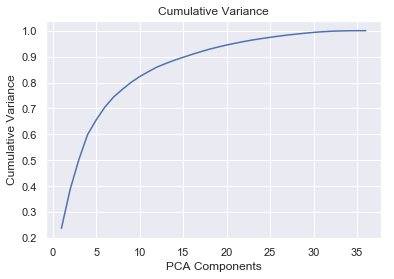

In [12]:
pca_cumvar = np.cumsum(pca.explained_variance_ratio_) 

plt.plot(np.arange(1,len(pca_cumvar)+1), pca_cumvar)
plt.title('Cumulative Variance')
plt.xlabel('PCA Components')
plt.ylabel('Cumulative Variance');

In [13]:
print('Number of Components to explain 80% Variance: {}'.format(np.argmax(pca_cumvar >= 0.8)+1))
print('Number of Components to explain 90% Variance: {}'.format(np.argmax(pca_cumvar >= 0.9)+1))

Number of Components to explain 80% Variance: 9
Number of Components to explain 90% Variance: 16


In [14]:
# 80% variation
pca9 = PCA(n_components=9).fit(X_train_scaled)
X_train_pca9 = pca9.transform(X_train_scaled)
X_valid_pca9 = pca9.transform(X_valid_scaled)

# 90% variation
pca16 = PCA(n_components=16).fit(X_train_scaled)
X_train_pca16 = pca16.transform(X_train_scaled)
X_valid_pca16 = pca16.transform(X_valid_scaled)

# fit models
pcr9_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca9, y_train)
pcr16_mod = LogisticRegressionCV(solver = 'lbfgs', 
                               max_iter = 5000, 
                               cv = 5, 
                               multi_class='multinomial').fit(X_train_pca16, y_train)

print(pcr9_mod.score(X_train_pca9, y_train))
print(pcr9_mod.score(X_valid_pca9, y_valid))
print(pcr16_mod.score(X_train_pca16, y_train))
print(pcr16_mod.score(X_valid_pca16, y_valid))

0.5260382333553065
0.49473684210526314
0.5214238628872775
0.5078947368421053


We can see that the variation in our model can be effectively summarized by the first 9 components. There seems to be not much difference in training and validation accuracy for principal components regression with 9, 16 and all 36 components. We can check for the most ideal number of components.

In [15]:
grp_id = [0 if len(i) == 1 else 1 for i in grp]

pcr_train_score = []
pcr_valid_score = []
pcr_test_score = []

for i in np.arange(1, X_train.shape[1]):
    pca_cv = PCA(n_components=i).fit(X_train_scaled)
    X_train_pca_cv = pca_cv.transform(X_train_scaled)
    X_valid_pca_cv = pca_cv.transform(X_valid_scaled)
    X_test_pca_cv = pca_cv.transform(X_test_scaled)
    
    pcr_cv_mod = LogisticRegressionCV(solver = 'lbfgs', 
                                      max_iter = 5000, 
                                      cv = 5, 
                                      multi_class='multinomial').fit(X_train_pca_cv, y_train)
    
    pcr_train_score.append(pcr_cv_mod.score(X_train_pca_cv, y_train))
    pcr_valid_score.append(pcr_cv_mod.score(X_valid_pca_cv, y_valid))
    pcr_test_score.append(accuracy_score(test['home_win'],
                                        [np.where(np.argsort(val) == 1)-1 if (i==1) & (np.argmax(val) == 1) else np.argmax(val)-1 for i, val in zip(grp_id, pcr_cv_mod.predict_proba(X_test_pca_cv))]))


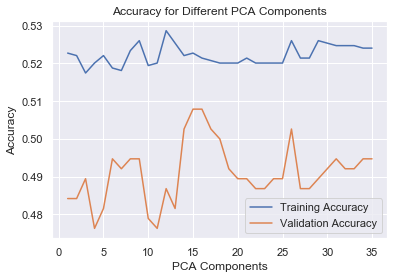

In [16]:
plt.plot(np.arange(1,len(pcr_train_score)+1), pcr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(pcr_valid_score)+1), pcr_valid_score, label='Validation Accuracy')


plt.title('Accuracy for Different PCA Components')
plt.xlabel('PCA Components')
plt.ylabel('Accuracy')
plt.legend();

In [17]:
print('Best Validation Accuracy Number of Components: {}'.format(np.argmax(pcr_valid_score)+1))

Best Validation Accuracy Number of Components: 15


In [18]:
# test set
X_test_pca16 = pca16.transform(X_test_scaled)

pcr_test_pred = [np.where(np.argsort(val) == 1)-1 if (i==1) & (np.argmax(val) == 1) else np.argmax(val)-1 for i, val in zip(grp_id, pcr16_mod.predict_proba(X_test_pca16))]


accuracy_score(test['home_win'], pcr_test_pred)

0.609375

Note that in this case, the best number of components for our validation set is not the best number of components for our test set.

## Partial Least Square Discriminant Analysis

Extending from PCR, we can try out PLS-DA as well to better account for the variation between predictors in relation to the response variable.

In [19]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
y_train_lb = lb.fit_transform(y_train)

In [20]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score

plsr_train_score = []
plsr_valid_score = []

for i in np.arange(1, X_train.shape[1]):
    plsr_mod = PLSRegression(n_components=i, scale=False) 
    plsr_mod.fit(X_train_scaled, y_train_lb)

    plsr_train_score.append(accuracy_score(y_train, np.argmax(plsr_mod.predict(X_train_scaled), axis=1) - 1))
    plsr_valid_score.append(accuracy_score(y_valid, np.argmax(plsr_mod.predict(X_valid_scaled), axis=1) - 1))

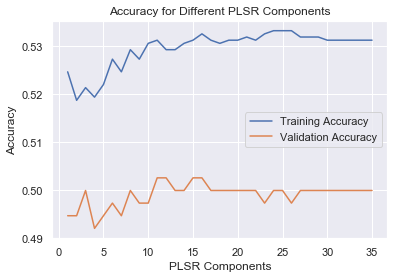

In [21]:
plt.plot(np.arange(1,len(plsr_train_score)+1), plsr_train_score, label='Training Accuracy')
plt.plot(np.arange(1,len(plsr_valid_score)+1), plsr_valid_score, label='Validation Accuracy')

plt.title('Accuracy for Different PLSR Components')
plt.xlabel('PLSR Components')
plt.ylabel('Accuracy')
plt.legend();

In [22]:
print('Best Validation Accuracy Number of Components: {}'.format(np.argmax(plsr_valid_score)+1))

Best Validation Accuracy Number of Components: 11


In [23]:
# check test accuracy
plsr11_mod = PLSRegression(n_components=11, scale=False) 
plsr11_mod.fit(X_train_scaled, y_train_lb)

plsr11_test_pred = [np.where(np.argsort(val) == 1)-1 if (i==1) & (np.argmax(val) == 1) else np.argmax(val)-1 for i, val in zip(grp_id, plsr11_mod.predict(X_test_scaled))]

accuracy_score(test['home_win'], plsr11_test_pred)

0.671875

In [24]:
plsr_test_score = []

for i in np.arange(1, X_train.shape[1]):
    plsr_mod = PLSRegression(n_components=i, scale=False)
    plsr_mod.fit(X_train_scaled, y_train_lb)
    
    test_pred = [np.where(np.argsort(val) == 1)-1 if (i==1) & (np.argmax(val) == 1) else np.argmax(val)-1 for i, val in zip(grp_id, plsr_mod.predict(X_test_scaled))]
    plsr_test_score.append(accuracy_score(test['home_win'], test_pred))

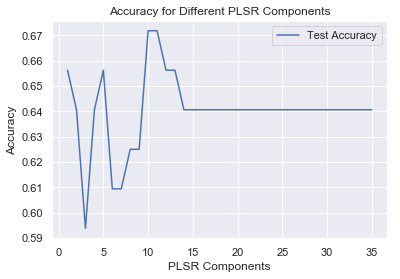

In [25]:
plt.plot(np.arange(1,len(plsr_test_score)+1), plsr_test_score, label='Test Accuracy')

plt.title('Accuracy for Different PLSR Components')
plt.xlabel('PLSR Components')
plt.ylabel('Accuracy')
plt.legend();

Note that the best number of components for our validation set is the best number of components for our test set as well.